# Starbucks Capstone Project Overview

## Introduction
This capstone project utilizes data provided by Udacity as part of the Data Scientist Nanodegree course. The dataset contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Starbucks periodically sends offers to mobile app users. However, not all users receive the same offer, and some may not receive any offers during certain weeks.

In this project, we employ machine learning classification models to:

1. Identify the key factors influencing the effectiveness of offers.
2. Explore the feasibility of using the model to predict whether a user will respond to an offer.
3. Investigate user characteristics associated with offer uptake.

## Offer Mechanics
For example, a user could receive a "BOGO" (buy one get one free) offer on a Monday, valid for 7 days from receipt. If the customer makes a purchase within the validity period, the offer is considered completed. Notably, users do not need to actively accept the offers they receive. A user might receive an offer, never open it, yet still complete it within the specified timeframe.

## Objectives
The project aims to address two main questions:

1. What are the primary drivers of an effective offer on the Starbucks app?
2. Can the provided data, including offer characteristics and user demographics, predict whether a user will accept an offer?

## Datasets
Three datasets are provided for this project:

- `portfolio.json`: Contains attributes of each offer (duration, type, etc.)
- `profile.json`: Demographic data for each customer
- `transcript.json`: Records for transactions, offers received, offers viewed, and offers completed

Please note that these datasets represent a simplified version of the real Starbucks app, as the simulator used here has only one product, while Starbucks offers many products.

## Classification Models
To answer the main questions, we employ three supervised classification machine learning models, each using data from different offer types. These models predict customer responses to offers. Additionally, we analyze feature importance to determine the main factors contributing to offer effectiveness. The classification models used in this project include:

- Decision Tree Classifier
- Random Forest Classifier
- Regression Model


### Import the libraries and packages, and load the datasets

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# Define file paths
portfolio_path = 'portfolio.json'
profile_path = 'profile.json'
transcript_path = 'transcript.json'

# Read the datasets from JSON files
with open(portfolio_path, 'r') as portfolio_file:
    portfolio = pd.read_json(portfolio_file, orient='records', lines=True)

with open(profile_path, 'r') as profile_file:
    profile = pd.read_json(profile_file, orient='records', lines=True)

with open(transcript_path, 'r') as transcript_file:
    transcript = pd.read_json(transcript_file, orient='records', lines=True)

In [2]:
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# Data Exploration
To enhance our analysis in the upcoming sections, our initial step involves a thorough exploration of the datasets. This exploration encompasses tasks such as identifying missing values, visualizing data distributions, and more. By doing so, we gain valuable insights into the dataset's characteristics and can develop a strategy for data preprocessing to prepare it for modeling.


# Portfolio Dataset Schema

Based on the details supplied by Udacity, the schema for the `portfolio.json` dataset is as follows:

- `id` (string): Offer ID
- `offer_type` (string): Type of offer, such as BOGO, discount, or informational
- `difficulty` (int): Minimum spending requirement to fulfill an offer
- `reward` (int): Reward provided upon the successful completion of an offer
- `duration` (int): Offer duration
- `channels` (list of strings): List of communication channels associated with the offer


In [4]:
def explore_portfolio_data(portfolio):
    '''
    Explore the 'portfolio' DataFrame, including its shape, first few rows, unique offer count, offer type counts, and column renaming.

    Inputs:
    - portfolio: DataFrame containing portfolio data.

    Outputs:
    - Returns the updated DataFrame with the 'id' column renamed to 'offer_id'.
    '''
    
    # Print the shape of the 'portfolio' DataFrame
    print(f"Shape of 'portfolio' DataFrame: {portfolio.shape}")

    # Display the first few rows of the 'portfolio' DataFrame
    print("\nFirst few rows of 'portfolio' DataFrame:")
    print(portfolio.head())

    # Count the number of unique offers in the 'portfolio' dataset
    unique_offer_count = portfolio['id'].nunique()
    print(f"\nNumber of unique offers: {unique_offer_count}")

    # Group and count offers of each type
    offer_counts = portfolio['offer_type'].value_counts()
    print("\nOffer type counts:")
    print(offer_counts)

    # Rename the 'id' column to 'offer_id' for clarity
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

    return portfolio

# Call the function to explore the 'portfolio' DataFrame
portfolio = explore_portfolio_data(portfolio.copy())

# Display the updated DataFrame
portfolio.head()


Shape of 'portfolio' DataFrame: (10, 6)

First few rows of 'portfolio' DataFrame:
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  

Number of unique offers: 10

Offer type counts:
bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64


,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


# Profile Dataset Schema

The `profile` dataset provides demographic data for customers, including the following attributes:

**profile.json**
* `age` (int) - age of the customer
* `became_member_on` (int) - the date when the customer created an app account
* `gender` (str) - gender of the customer (please note that some entries contain 'O' for 'Other' rather than 'M' or 'F')
* `id` (str) - customer ID
* `income` (float) - customer's income

This dataset contains demographic information about customers, allowing us to understand the profile of each customer.


In [5]:
def explore_profile_data(profile):
    
    '''
    Explore the 'profile' DataFrame, including displaying the first few rows, counting missing values, unique user count, and gender category counts.
    Inputs:
    - profile: DataFrame containing user profile data.

    Outputs:
    - Returns the DataFrame with missing values counted and gender category counts.
    '''
    
    # Display the first few rows of the 'profile' dataset
    print("First few rows of 'profile' DataFrame:")
    print(profile.head())

    # Count the missing values in each column of the 'profile' dataset
    missing_values = profile.isnull().sum()
    print("\nMissing values in each column:")
    print(missing_values)

    # Calculate the number of unique users in the 'profile' dataset
    unique_user_count = profile['id'].nunique()
    print(f"\nNumber of unique users: {unique_user_count}")

    # Count the occurrences of each gender category in the 'gender' column of the 'profile' dataset
    gender_counts = profile['gender'].value_counts()
    print("\nGender category counts:")
    print(gender_counts)

    return profile

# Call the function to explore the 'profile' DataFrame
profile = explore_profile_data(profile.copy())

# Display the original DataFrame
profile.head()


First few rows of 'profile' DataFrame:
  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

Missing values in each column:
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Number of unique users: 17000

Gender category counts:
M    8484
F    6129
O     212
Name: gender, dtype: int64


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


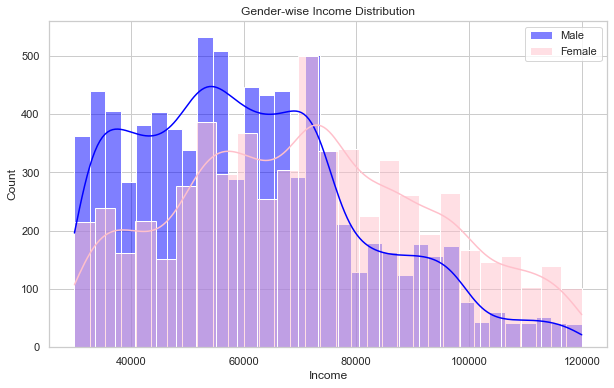

In [6]:
# Set the figure style using Seaborn
sns.set(style="whitegrid")

# Filter the 'profile' dataset for male and female genders
male_data = profile[profile.gender == 'M']
female_data = profile[profile.gender == 'F']

# Create subplots with two side-by-side histograms
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=male_data, x='income', kde=True, label='Male', color='blue', ax=ax)
sns.histplot(data=female_data, x='income', kde=True, label='Female', color='pink', ax=ax)

# Add labels and a title
ax.set_xlabel('Income')
ax.set_ylabel('Count')
ax.set_title('Gender-wise Income Distribution')

# Add a legend
ax.legend()

# Show the plot
plt.show()


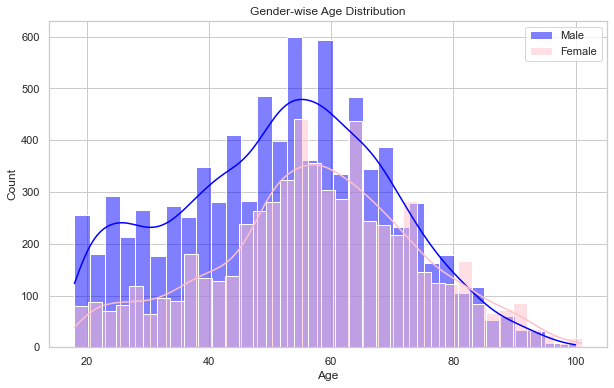

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure style using Seaborn
sns.set(style="whitegrid")

# Filter the 'profile' dataset for male and female genders
male_data = profile[profile.gender == 'M']
female_data = profile[profile.gender == 'F']

# Create subplots with two side-by-side histograms
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=male_data, x='age', kde=True, label='Male', color='blue', ax=ax)
sns.histplot(data=female_data, x='age', kde=True, label='Female', color='pink', ax=ax)

# Add labels and a title
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('Gender-wise Age Distribution')

# Add a legend
ax.legend()

# Show the plot
plt.show()

The "became_member_on" column can be feature engineered to calculate the tenure of membership in days.

In [8]:
# Display the first few entries in the 'became_member_on' column
profile['became_member_on'].head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

# Transcript Dataset Schema

The schema for the transactional data is as follows:

**transcript.json**
- `event` (str): Record description (e.g., transaction, offer received, offer viewed, etc.)
- `person` (str): Customer ID
- `time` (int): Time in hours. The data begins at time t=0
- `value` (dict of strings): Contains either an offer ID or transaction amount depending on the record


In [9]:

def clean_transcript_data(transcript):
    '''
    Clean and explore the 'transcript' DataFrame, including displaying the first few rows, checking for missing values, 
    extracting values from the 'value' column, cleaning the 'offer_id' column, and displaying a cleaned data preview.

    Inputs:
    - transcript: DataFrame containing transaction and event data.

    Outputs:
    - Returns the cleaned 'transcript' DataFrame.
    '''
    
    # Display the first 5 rows of the 'transcript' DataFrame for a quick overview
    transcript_head = transcript.head(5)
    print("First 5 rows of 'transcript' DataFrame:")
    print(transcript_head)
    
    # Check for missing values in the 'transcript' DataFrame
    missing_values = transcript.isnull().sum()
    print("\nMissing values in each column:")
    print(missing_values)
    
    # Calculate and display the distribution of events in the 'transcript' DataFrame
    event_distribution = transcript['event'].value_counts()
    print("\nEvent distribution:")
    print(event_distribution)
    
    # Extract values from the 'value' column and expand them into separate columns
    transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
    
    # Display the first few rows of the expanded DataFrame
    print("\nFirst few rows of the expanded DataFrame:")
    print(transcript.head())
    
    # Clean up the duplicates in offer id and offer_id and merge into one column 'offer_id'
    transcript['clean_id'] = np.where(
        transcript['offer id'].isnull() & transcript['offer_id'].notnull(),
        transcript['offer_id'],
        transcript['offer id']
    )
    
    # Drop the original id columns
    transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)
    
    # Rename the 'clean_id' column to 'offer_id' for clarity
    transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)
    
    # Display the first few rows of the cleaned 'transcript' DataFrame to check the results
    transcript_preview = transcript.head()
    print("\nCleaned 'transcript' DataFrame preview:")
    print(transcript_preview)
    
    return transcript

# Call the function to clean and explore the 'transcript' DataFrame
transcript = clean_transcript_data(transcript.copy())

# Display the cleaned DataFrame
transcript.head()


First 5 rows of 'transcript' DataFrame:
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  

Missing values in each column:
person    0
event     0
value     0
time      0
dtype: int64

Event distribution:
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

First few rows of the ex

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [10]:
# Count the number of unique 'offer_id' values in the 'transcript' DataFrame
unique_offer_ids = transcript['offer_id'].nunique()

# Display the count of unique 'offer_id' values
unique_offer_ids

10

In [11]:
# Count the number of unique customers (persons) in the 'transcript' DataFrame
unique_customers = transcript['person'].nunique()

# Display the count of unique customers
unique_customers

17000

The number of individuals in the 'transcript' dataset matches the number of individuals in the Demographics Data.

In [12]:
def merge_and_group_data(transcript, portfolio):
    '''
    Merge the 'transcript' and 'portfolio' DataFrames based on the 'offer_id' column, 
    and then group the data by 'offer_type' and 'event' to count the number of persons in each group.

    Inputs:
    - transcript: DataFrame containing transaction and event data.
    - portfolio: DataFrame containing offer portfolio data.

    Outputs:
    - Returns a DataFrame with counts of persons for each combination of 'offer_type' and 'event'.
    '''
    
    # Merge the 'transcript' and 'portfolio' DataFrames based on the 'offer_id' column
    merged_data = pd.merge(transcript, portfolio, how='left', on='offer_id')
    
    # Group the merged DataFrame by 'offer_type' and 'event' and count the number of persons in each group
    offer_event_counts = merged_data.groupby(['offer_type', 'event'])['person'].count().reset_index()
    
    return offer_event_counts

# Call the function to merge and group the data
offer_event_counts = merge_and_group_data(transcript.copy(), portfolio.copy())

# Display the resulting DataFrame
offer_event_counts


,offer_type,event,person
0,bogo,offer completed,15669
1,bogo,offer received,30499
2,bogo,offer viewed,25449
3,discount,offer completed,17910
4,discount,offer received,30543
5,discount,offer viewed,21445
6,informational,offer received,15235
7,informational,offer viewed,10831


- We can observe that for the informational offer type, there is no "offer completed" event recorded. Therefore, we can consider a transaction as the equivalent of an "offer completed" event.

# Defining Approach for Preprocessing

To identify the primary drivers of an effective offer within the Starbucks app, we first need to establish what constitutes an 'effective' offer. This necessitates further exploration of the datasets and how all three (transcript, portfolio, demographics) interact.

We have identified four types of events: "offer completed," "offer received," "offer viewed," and "transaction." However, it's worth noting that our data lacks offer IDs associated with transactions, as they are not recorded in the transcript event data. Therefore, our initial preprocessing objective is to establish a methodology for assigning offer IDs to specific transactions.

Furthermore, BOGO and discount offers are considered effective when certain events occur in the correct time sequence:
1. For BOGO and discount offers, an offer is deemed effective if the following events are recorded in the right time sequence:
   - offer received : offer viewed : transaction : offer completed

2. Conversely, informational offers are considered effective when the following sequence occurs:
   - offer received : offer viewed : transaction

In [13]:
# Merge the 'transcript' and 'portfolio' DataFrames based on the 'offer_id' column
transcript = transcript.merge(portfolio, how='left', on='offer_id')

# Group the merged DataFrame by 'event' and 'offer_type' and count the occurrences
transcript.groupby(['event', 'offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

# Data Refinement

## Assigning Offer IDs to Transactions

One of the initial preprocessing tasks is to assign offer IDs to specific transactions, as transactions do not have offer IDs associated with them.

We categorize our customers into four main groups:

**group 1: People who are influenced and successfully complete - Effective Offers:**
   - `offer received` : `offer viewed` : `transaction` : `offer completed` (BOGO/discount offers)
   - `offer received` : `offer viewed` : `transaction` (informational offers - must be within the validity period of the offer)

**group 2: People who received and viewed an offer but did not successfully complete - Ineffective Offers:**
   - `offer received` : `offer viewed`

**group 3: People who purchase/complete offers regardless of awareness of any offers:**
   - `transaction`
   - `offer received` : `transaction` : `offer completed` : `offer viewed`
   - `transaction` : `offer received` : `offer completed` : `offer viewed`
   - `offer received` : `transaction` : `offer viewed` : `offer completed`
   - `offer received` : `transaction` (informational offers)
   - `offer received` : `transaction` : `offer viewed` (informational offers)

**group 4: People who received offers but no action taken:**
   - `offer received`

It's essential to separate people in group 2 from people in group 4, as group 2 might have viewed an offer but took no action, while group 4 did not even have an offer viewed event.

Segmenting people in group 1 (effective offers) and people who purchase/complete offers regardless of awareness (group 3) is challenging. For group 3, a conversion is not valid if an offer completed or transaction occurs before an offer viewed event. There may also be scenarios where an offer completed happens after viewing the offer but after a transaction. In such cases, the offer might be completed, but it's still not a valid conversion.

**Defining the Target Variable "Effective Offer":**

Group 1 customers will be our target variable with "effective_offer" = 1. Group 2 customers fall under our definition of an ineffective offer, and they have "effective_offer" = 0.

What about group 3 and group 4? Group 3 consists of users who might have received offers but would have made purchases regardless. From a business perspective, we would not want to send them offers.

Meanwhile, group 4 users are considered low-priority customers, as they do not take any action, regardless of receiving offers or not. We can deprioritize group 3 and group 4 users from our model.

These conditions serve as the basis for assigning the offer ID that 'influences' a transaction by ensuring that the transaction occurs after an offer viewed event.

After sorting the transcript dataset by person and time to ensure that each event for each person occurs in sequence, we filter the dataset to include only events 'offer viewed' and 'transaction' in the correct order. Then, we use the pandas `ffill()` method to fill every transaction with the offer ID of the viewed offer, but only if it occurs before the transaction.

Since 'offer_id' is not associated with any 'transaction' event, we need to establish a link between the offer ID and all transaction events to determine whether the offer has been successfully completed with a transaction.

For BOGO and discount offers, the sequence of events includes 'offer received,' 'offer viewed,' 'transaction,' and 'offer completed.' This sequence clearly indicates that the offer has been redeemed and should be sent out as effective.

In the case of informational offers, while there's no reward step like 'offer completed,' there should still be a 'transaction' event associated with the usage of the offer. This 'transaction' event signifies that the offer has been utilized, even though it doesn't have a traditional reward step.

This linkage process allows us to identify completed offers, both for BOGO/discount and informational offers.

In [14]:
def clean_transcript(transcript, portfolio):
    '''
    Clean and process the 'transcript' DataFrame by dropping useless columns, sorting, filling missing offer IDs, and merging with the 'portfolio' DataFrame.

    Inputs:
    - transcript: DataFrame containing transaction and event data.
    - portfolio: DataFrame containing offer portfolio data.

    Outputs:
    - Returns a cleaned and processed DataFrame.
    '''

    # Drop the useless columns 'reward_x' and 'reward_y'
    transcript_refined = transcript.drop(columns=['reward_x', 'reward_y'], axis=1,inplace=False)

    # Sort the 'transcript_refined' DataFrame by 'person' and 'time'
    transcript_refined = transcript_refined.sort_values(by=['person', 'time'])

    # Filter the dataset for transactions that occur after an offer is viewed and forward fill offer IDs by person
    completed_transactions = transcript_refined[['time', 'offer_id', 'person', 'event']][
        (transcript_refined['event'] == 'transaction') | (transcript_refined['event'] == 'offer viewed')]
    completed_transactions.update(completed_transactions.groupby(['person']).ffill())
    completed_transactions['offer_id'] = completed_transactions['offer_id'].ffill()

    # Merge the filled offer IDs back into the 'transcript_refined' DataFrame
    transcript_refined = transcript_refined.merge(completed_transactions, how='left', on=['person', 'time', 'event'])

    # Clean up the DataFrame by selecting the appropriate offer_id column and dropping the dummy columns
    transcript_refined['offer_id'] = np.where(transcript_refined['offer_id_x'].isnull(),\
                                               transcript_refined['offer_id_y'], transcript_refined['offer_id_x'])
    transcript_refined.drop(columns=['offer_id_x', 'offer_id_y'], axis=1, inplace=True)

    # Merge the 'portfolio' dataset to get offer data
    transcript_refined = transcript_refined.merge(portfolio, how='left', on='offer_id')
    transcript_refined['duration'] = np.where(transcript_refined['duration_x'].isnull(), \
                                               transcript_refined['duration_y'], transcript_refined['duration_x'])
    transcript_refined.drop(columns=['duration_x', 'offer_type_x', 'difficulty_x', 'channels_x', 'duration_y'],\
                            axis=1, inplace=True)
    transcript_refined.rename(columns={'channels_y': 'channels', 'reward_y': 'reward', 'difficulty_y': 'difficulty',\
                                       'offer_type_y': 'offer_type'}, inplace=True)

    return transcript_refined

# Call the function to clean and process the 'transcript' DataFrame
transcript_refined = clean_transcript(transcript.copy(), portfolio.copy())

# Display the cleaned and processed DataFrame
transcript_refined.head()


,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0


## Transactions and Offers Completed after Offer Viewed

The next crucial step in preparing our data for modeling and analysis is to identify completed offers and transactions that occur after an offer is viewed.

Once we have successfully assigned a transaction as occurring after an offer is viewed, we can utilize this information to subset our data based on the previously defined groups and perform analysis within each group.

Since we have already filled in all transaction's offer IDs, we can extract the transactions that have converted from offers by checking if the offer ID before the transaction matches the transaction's offer ID.

This means that as long as the events "offer viewed," "transaction," and "offer completed" occur in the same event space and are in the correct chronological order, we can confidently conclude that it is a transaction and/or a completed offer occurring only after an offer is viewed.

To achieve this, I created a new column to flag the previous offer ID using the `shift` function provided by the Pandas library.


In [15]:
def refine_transcript(transcript_refined):
    '''
    Process the 'transcript_refined' DataFrame by generating previous offer IDs and creating flags for completed offers that were viewed.

    Inputs:
    - transcript_refined: DataFrame containing cleaned transaction and event data.

    Outputs:
    - Returns a processed DataFrame.
    '''

    # Define the events of interest
    events_of_interest = ['offer viewed', 'transaction', 'offer completed']

    # Subset the dataset with only the events of interest
    viewed_transactions = transcript_refined[transcript_refined['event'].isin(events_of_interest)].copy()

    # Generate the previous offer id for each person and offer
    viewed_transactions['pre_offer_id'] = viewed_transactions.groupby(['person', 'offer_id'])['offer_id'].shift()

    # Create a flag for completed offers that were viewed by the customer
    viewed_transactions['completed_offer'] = np.where(viewed_transactions['pre_offer_id'] == viewed_transactions['offer_id'], 1, 0)

    # Filter the 'offer received' events
    received_transactions = transcript_refined[transcript_refined['event'] == 'offer received']

    # Create 'pre_offer_id' and 'completed_offer' columns with NaN values
    received_transactions['pre_offer_id'] = np.nan
    received_transactions['completed_offer'] = np.nan

    # Concatenate the DataFrames
    transcript_refined = pd.concat([received_transactions, viewed_transactions], ignore_index=True)
    transcript_refined.sort_values(['person', 'time'])

    return transcript_refined

# Call the function to process the 'transcript_refined' DataFrame
transcript_refined = refine_transcript(transcript_refined.copy())

# Display the processed DataFrame
transcript_refined.head()


C:\Users\farhad\AppData\Local\Temp/ipykernel_33572/4001103589.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  received_transactions['pre_offer_id'] = np.nan
C:\Users\farhad\AppData\Local\Temp/ipykernel_33572/4001103589.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  received_transactions['completed_offer'] = np.nan


,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,NaN,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,10.0,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,NaN,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,discount,7.0,NaN,NaN


## Separating Transcript Data by Offer Type

Since different offers have varying completion consequences, such as the absence of rewards for informational offers, it's beneficial to segment the transcript data by offer type. This separation will facilitate more straightforward and focused analysis.

In [16]:
def split_transcript_by_offer_type(transcript_refined):
    '''
    Split the 'transcript_refined' DataFrame into different offer types and store them in a dictionary.

    Inputs:
    - transcript_refined: DataFrame containing cleaned transaction and event data.

    Outputs:
    - Returns a dictionary where each key is an offer type label, and the corresponding value is a DataFrame for that offer type.
    '''

    # Define offer type labels
    offer_types = ['bogo', 'discount', 'informational']

    # Create a dictionary to store DataFrames for each offer type
    offer_type_data = {}

    # Split the transcript into different offer types and store them in the dictionary
    for offer_type in offer_types:
        offer_type_data[offer_type] = transcript_refined[transcript_refined['offer_type'] == offer_type].copy()

    return offer_type_data

# Call the function to split the 'transcript_refined' DataFrame by offer type
offer_type_data = split_transcript_by_offer_type(transcript_refined.copy())

# Access the DataFrames using the dictionary
bogo_offer = offer_type_data['bogo']
discount_offer = offer_type_data['discount']
informational_offer = offer_type_data['informational']

bogo_offer.head()


,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
2,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,NaN,NaN
5,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,NaN,NaN
6,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,NaN,NaN
11,0011e0d4e6b944f998e987f904e8c1e5,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,bogo,7.0,NaN,NaN
13,0020c2b971eb4e9188eac86d93036a77,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,bogo,7.0,NaN,NaN


## Separating Conversion Events within Each Offer Type

Within each offer type, we have successfully distinguished individuals with a unique combination of person-offer_id in Group 1 from the others. We accomplished this using our `completed_offer` column, which identifies completion events.

We can confidently assert that completion events flagged with `valid_completed=1` belong to the first group—those who were influenced by the offer and successfully converted (effective offers).

For BOGO and discount offers, we only consider "offer completed" events as completion events. On the other hand, for informational offers, we consider "transaction" events as conversion events.

This approach helps us differentiate between the types of completion events based on the offer type.

# Separating Group 1 for BOGO and Discount Offers

In [17]:
bogo_fulfilled_group1 = bogo_offer[['person','offer_id']][(bogo_offer['completed_offer']==1) & (bogo_offer['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_fulfilled_group1 = discount_offer[['person','offer_id']][(discount_offer['completed_offer']==1) & (discount_offer['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

**Group 1 Definition for Informational Offers**

For informational offers, the definition of Group 1 will be addressed later. This is because there is an additional consideration when it comes to transactions. To be considered as effective offers, transactions must occur within the validity period of an informational offer. We'll incorporate this criterion when defining Group 1 for informational offers.

**Group 3 Individuals**

Group 3 individuals are those who fall within the converted IDs category but did not have an "offer viewed" event prior. In other words, they are people who have "transaction" and "offer completed" events but no "offer viewed" event before them. For BOGO and discount offers, these individuals are those with "offer completed" events where the "completed_offer" is not equal to 1.

## Separating `Group 2` and `Group 4` for BOGO and Discount Offers

Next, we will focus on distinguishing unique person-offer_ids in `Group 2` and `Group 4` for BOGO and discount offers. We can make the assumption that every person who views an offer must have received an offer prior. Therefore, we can take the entire group of people who received an offer and later subset them into `Group 2` and `Group 4`.

In [18]:
def identify_groups_two_four(df):
    
    '''
    inputs:
    Takes in transcript dataframe of single offer type to check for people of group2 and group4.
    
    outputs:
    Returns dataframe containing unique person-offer_id pairs with completion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just completion events (transaction and offer_completed)
       
    '''
    
    #separate offer ids that have transactions or conversions by person and offer_id
    completion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    only_received_transactions=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create combined dataset to diffrentiate groups
    scan_integration=completion_ids.merge(only_received_transactions,how='right',on=['person','offer_id'],indicator=True)
    return scan_integration

#check how many are in either group
bogo_scan_integration=identify_groups_two_four(bogo_offer)
print('BOGO offers:')
print(bogo_scan_integration.groupby(['_merge']).count())

discount_scan_integration=identify_groups_two_four(discount_offer)
print('Discount offers:')
print(discount_scan_integration.groupby(['_merge']).count())

BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


## Identification of Groups 2 and 4

We've identified a significant number of unique person-offer_id pairs with "offer received" events but no conversion events. These pairs fall into Groups 2 and 4 within each offer type.

Next, based on the merged dataset created earlier, we can further categorize customers into two subgroups:

1. Customers who viewed the offer only after they received it.
2. Customers who didn't even open the offer after receiving it.

In [19]:
# Identify Group 2 and Group 4 individuals within BOGO offers

# Extract Group 2 and Group 4 from the merged dataset
bogo_groups_two_four = bogo_scan_integration[bogo_scan_integration['_merge'] == 'right_only']

# Merge with the original transcript to include more information
bogo_groups_two_four = bogo_groups_two_four.merge(transcript_refined, how='left', on=['person', 'offer_id'])

# Calculate Group 2 by counting 'offer viewed' events
bogo_group_two = bogo_groups_two_four[['person', 'offer_id']][bogo_groups_two_four['event'] == 'offer viewed'].groupby(['person', 'offer_id']).count().reset_index()

# Remove the '_merge' column
bogo_groups_two_four.drop(['_merge'], axis=1, inplace=True)

# Identify Group 4 individuals by comparing with Group 2
bogo_group_four = bogo_groups_two_four.merge(bogo_group_two[['person', 'offer_id']], how='left', indicator=True)
bogo_group_four = bogo_group_four[bogo_group_four['_merge'] == 'left_only'].copy()


In [20]:
# Identify Group 2 and Group 4 individuals within Discount offers

# Extract Group 2 and Group 4 from the merged dataset
discount_groups_two_four = discount_scan_integration[discount_scan_integration['_merge'] == 'right_only']

# Merge with the original transcript to include more information
discount_groups_two_four = discount_groups_two_four.merge(transcript_refined, how='left', on=['person', 'offer_id'])

# Calculate Group 2 by counting 'offer viewed' events
discount_group_two = discount_groups_two_four[['person', 'offer_id']][discount_groups_two_four['event'] == 'offer viewed'].groupby(['person', 'offer_id']).count().reset_index()

# Remove the '_merge' column
discount_groups_two_four.drop(['_merge'], axis=1, inplace=True)

# Identify Group 4 individuals by comparing with Group 2
discount_group_four = discount_groups_two_four.merge(discount_group_two[['person', 'offer_id']], how='left', indicator=True)
discount_group_four = discount_group_four[discount_group_four['_merge'] == 'left_only'].copy()

# Separating Group 3 for BOGO and Discount Offers

In [21]:
# subset the offer which has no correction with offer
bogo_group_three = bogo_offer[['person','offer_id']][(bogo_offer['event']=='offer completed') & (bogo_offer['completed_offer']!=1)]\
                    .groupby(['person','offer_id']).count().reset_index()
discount_group_three = discount_offer[['person','offer_id']][(discount_offer['event']=='offer completed')\
                    & (discount_offer['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

## Classification of Effective and Ineffective Offers

Now, let's classify offers as either effective or ineffective based on the group type. As explained earlier, any unique person-offer_id belonging to Group 1 will be categorized as effective_offer=1 in our target variable group. Meanwhile, individuals in Group 2 will be categorized as effective_offer=0 in our target variable group.

In [22]:
def create_modified_offers_data(group1_df, group2_df):
    
    # Assign the 'effective_offer' flag column
    group1_df['effective_offer'] = 1
    group2_df['effective_offer'] = 0

    # Append the datasets together
    final_offers = pd.concat([group1_df, group2_df], sort=False)
    return final_offers

bogo_final_offers = create_modified_offers_data(bogo_fulfilled_group1, bogo_group_two)
discount_final_offers = create_modified_offers_data(discount_fulfilled_group1, discount_group_two)

## Target Variable Preparation

We have successfully prepared the target variables for our BOGO and discount datasets.

However, for informational offers, there is an additional consideration before we can label the "effective offers" column — we need to account for the offer's validity.

## Considering Duration of Offers for Informational Offers

When determining the effectiveness or conversion of transactions and offers for 'informational' type offers, we need to consider an additional rule. Informational offers are treated differently because the conversion event is not an 'offer completed' event but a transaction.

To mark an 'informational' offer as effective, it must fall within the duration of the offer. 

As stated in our data dictionary, event times in the transcript data are given in hours. To ensure they are on the same scale as the offer duration, we convert these times into days.

For informational offers, we convert the time data into days, aligning it with the duration measurement used in the offers dataset.


In [23]:
# Convert time into days for informational offers
informational_offer['day_offer'] = informational_offer['time'] / 24

# Drop unnecessary columns
columns_to_drop = ['time', 'value', 'pre_offer_id']
informational_offer.drop(columns=columns_to_drop, inplace=True)

# Sort informational offers to ensure all events occur in order by person, day_offer, event, and offer_id
informational_offer.sort_values(['person', 'day_offer', 'event', 'offer_id'], inplace=True)

## Calculating Duration Using Pandas `diff` Function

To calculate the duration between two events, we can make use of the `diff` function in pandas. Specifically, we calculate the difference between the 'transaction' and 'offer received' events to determine the duration.


In [24]:
#get difference in time for informational offers
informational_offer['diff']=informational_offer[(informational_offer['offer_type']=='informational') & ((informational_offer['event']=='offer received') | (informational_offer['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [25]:
#create column for flagging valid events
informational_offer['valid_completed_duration']=np.nan
#flag valid events if within duration
informational_offer.loc[informational_offer['diff']<=informational_offer['duration'],'valid_completed_duration']=1
#fill any missing values with 0 flag
informational_offer['valid_completed_duration']=informational_offer['valid_completed_duration'].fillna(value=0)

In [26]:
informational_offer.head(1)

,person,event,amount,offer_id,reward,channels,difficulty,offer_type,duration,completed_offer,day_offer,diff,valid_completed_duration
0,0009655768c64bdeb2e877511632db8f,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,7.0,NaN,0.0


In [27]:
#flag effective_offers where completed_offer = 1 and valid_completed_duration = 1
informational_offer['offer_responded']=np.where(((informational_offer['completed_offer']==1)\
                                           & (informational_offer['valid_completed_duration']==1)),1,0)

In [28]:
informational_offer.head()

,person,event,amount,offer_id,reward,channels,difficulty,offer_type,duration,completed_offer,day_offer,diff,valid_completed_duration,offer_responded
0,0009655768c64bdeb2e877511632db8f,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,7.0,NaN,0.0,0
76277,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,0.0,8.0,NaN,0.0,0
76278,0009655768c64bdeb2e877511632db8f,transaction,22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,1.0,9.5,2.5,1.0,1
1,0009655768c64bdeb2e877511632db8f,offer received,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,14.0,NaN,0.0,0
76279,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,0.0,15.5,NaN,0.0,0


In [29]:
#separate group 1 in transcript_into
final_dataset = informational_offer[['person','offer_id']][informational_offer['offer_responded']==1]\
                        .groupby(['person','offer_id']).sum().reset_index()

In [30]:
#separate out group 2 of customers
scan_integration_dataset=identify_groups_two_four(informational_offer)
print('For informational offers:')
print(scan_integration_dataset.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [31]:
dataset_groups_two_four = scan_integration_dataset[scan_integration_dataset['_merge'] == 'right_only']
dataset_groups_two_four  = dataset_groups_two_four.merge(transcript_refined,how='left',on=['person','offer_id'])
dataset_group_two = dataset_groups_two_four[['person','offer_id']][dataset_groups_two_four['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
dataset_groups_two_four.drop(['_merge'], axis=1, inplace=True)
dataset_group_four=dataset_groups_two_four.merge(dataset_group_two[['person','offer_id']],how='left',indicator=True)
dataset_group_four=dataset_group_four[dataset_group_four['_merge']=='left_only'].copy()

In [32]:
#scenario 1
dataset_groups_three_one = informational_offer[['person','offer_id']][(informational_offer['event']=='transaction')&(informational_offer['completed_offer']!=1) & (informational_offer['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
dataset_groups_three_two = informational_offer[['person','offer_id']][(informational_offer['event']=='transaction')&(informational_offer['completed_offer']==1) & (informational_offer['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
dataset_group_three = dataset_groups_three_one.append(dataset_groups_three_two,sort=False)
del dataset_groups_three_one
del dataset_groups_three_two

In [33]:
dataset_offers=create_modified_offers_data(final_dataset,dataset_group_two)

# Feature Engineering
**Now, let's explore feature engineering to extract valuable insights from the dataset.**

## 1. Engineering the 'became_member_on' Column
The 'became_member_on' column is currently in date format. To derive meaningful insights from this feature, we will convert it into a feature that represents the membership tenure of each customer. This new feature can potentially impact our prediction of whether a customer will respond to an offer or not.



In [34]:
profile.rename(columns={'id':'person'},inplace=True)

#create function to generate the length of time since the user become the member
def membership_period(df):
    '''
    inputs:
    - df: dataframe to generate the length of time since the user become the member
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-4:-2]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

bogo_final_offers=membership_period(bogo_final_offers)
discount_final_offers=membership_period(discount_final_offers)
dataset_offers=membership_period(dataset_offers)

bogo_final_offers.tail()

,person,offer_id,effective_offer,gender,age,income,membership_days
13215,ffda4545e7084ff6aaf01304fb1c1fa6,f19421c1d4aa40978ebb69ca19b0e20d,0,F,67,95000.0,231.0
13216,ffed75d3abc64b488982f50ed12878b5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,M,20,44000.0,105.0
13217,ffed75d3abc64b488982f50ed12878b5,ae264e3637204a6fb9bb56bc8210ddfd,0,M,20,44000.0,105.0
13218,fff7576017104bcc8677a8d63322b5e1,ae264e3637204a6fb9bb56bc8210ddfd,0,M,71,73000.0,696.0
13219,fff8957ea8b240a6b5e634b6ee8eafcf,4d5c57ea9a6940dd891ad53e9dbe8da0,0,M,71,56000.0,78.0


## 2. Count of Offers Received

During further data exploration, I uncovered that each person can receive multiple offers. The number of times a customer receives an offer may also have an impact on whether the offers are effective or not.


**Hypothesis: Frequency of Offers Received**

I formulated a hypothesis that the frequency of offers received by each person could influence the effectiveness of offers. To investigate this hypothesis, I decided to create a new feature called `offer_received_cnt` to capture the frequency of offers received by each customer.


In [35]:
def create_offer_received_count(df):
    '''
    Create a DataFrame with the count of offers received per person and offer.
    
    Args:
    - df: The input DataFrame containing transcript data.
    
    Returns:
    - DataFrame with columns: ['person', 'offer_id', 'offer_received_cnt']
    '''
    
    # Filter the DataFrame for 'offer received' events
    offer_received_df = df[df['event'] == 'offer received']
    
    # Group by 'person' and 'offer_id' and count the number of 'offer received' events
    offer_received_count = offer_received_df.groupby(['person', 'offer_id'])['event'].count().reset_index()
    
    # Rename the 'event' column to 'offer_received_cnt'
    offer_received_count.rename(columns={'event': 'offer_received_cnt'}, inplace=True)
    
    return offer_received_count

# Create the offer received count DataFrame
received_offer_No = create_offer_received_count(transcript_refined)


### 3. Handling 'Invalid' Transactions

I wanted to explore how many transactions could be considered 'invalid' based on my definition. These transactions typically involve people not in Group 1. Normally, such transactions could be summed up as transactions by users who are not in Group 1. 

The primary purpose of offers is to drive purchases. Users who tend to spend more in their transactions are often flagged as having effective offers. 

In my dataset, I have already separated transactions into two categories: those that are conversions resulting from offers and those that are part of a user's normal purchasing behavior. This distinction is made through the 'completed_offer' column, which checks if a transaction had an 'offer viewed' event prior.

For transactions where 'completed_offer' is 1, I have included them in my 'effective offers' flag for BOGO and Discount offers. However, for transactions where 'completed_offer' is 0, I have not considered them. 

These 'invalid transactions' could potentially be valuable as a feature to represent the user's 'baseline' spending behavior. The idea is to explore if there is a baseline level of spending for users highly influenced by certain offers (in Group 1) and Group 2, and whether this baseline spending can predict a user's propensity to take up an offer.


In [36]:
def calculate_invalid_transaction_amount(df):
    '''
    Calculate the total amount of 'invalid' transactions not related to offers.

    inputs:
    - transcript_processed: DataFrame containing processed transcript data

    outputs:
    - Returns a DataFrame with the total 'invalid' transaction amount per person and offer_id.
    '''
    
    # Filter the dataset for 'invalid' transactions
    invalid_transactions = df[(df['event'] == 'transaction') & (df['completed_offer'] == 0)]
    
    # Calculate the total 'invalid' transaction amount per person and offer_id
    invalid_transaction_amount = invalid_transactions.groupby(['person', 'offer_id'])['amount'].sum().reset_index()
    
    # Rename the 'amount' column to 'amount_invalid' for clarity
    invalid_transaction_amount.rename(columns={'amount': 'amount_invalid'}, inplace=True)
    
    return invalid_transaction_amount

invalid_transaction = calculate_invalid_transaction_amount(transcript_refined)


# Preparing Data for Implementation

Now, let's prepare the data for modeling.

**- Merge with Temporary Datasets**: We'll start by merging the main dataset with the temporary datasets created earlier to include the engineered features.

**- Handle Missing Values**: We'll address missing values in the gender, income, and any abnormal age value columns for the demographic data. Additionally, we'll convert the gender column into dummy variables to make it suitable for modeling.

**- Categorical Variables**: We'll handle the channel column by separating it into categorical variables.

**- Duplicate Records**: Lastly, we'll take care of any duplicate records in the dataset.

Let's proceed with these steps to get our data ready for modeling.


In [37]:
def prepare_data_for_modeling(df):
    # Merge to get offers received count and invalid amount transacted
    df = df.merge(received_offer_No[['person', 'offer_id', 'offer_received_cnt']], how='left', on=['person', 'offer_id'])
    df = df.merge(invalid_transaction[['person', 'offer_id', 'amount_invalid']], how='left', on=['person', 'offer_id'])

    # Check the percentage of missing values in the dataset
    missing_percentages = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    
    # Fill missing values for amount_invalid with 0
    df['amount_invalid'] = df['amount_invalid'].fillna(value=0)
    
    # Drop rows with missing values
    df.dropna(inplace=True)

    # Merge with portfolio to get offer details
    df = df.merge(portfolio, how='left', on='offer_id')
    
    
    '''
    # Convert channels into categorical variables
    for index, row in df.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in df.loc[index, 'channels']:
                df.loc[index, channel] = 1
            else:
                df.loc[index, channel] = 0
    
    # Drop the 'channels' column
    df = df.drop(['channels'], axis=1, inplace=False)
    '''
    # Convert 'channels' into categorical variables
    for channel in ['web', 'email', 'social', 'mobile']:
        df[channel] = df['channels'].apply(lambda x: 1 if channel in x else 0)
    df.drop(columns=['channels'], axis=1, inplace=True)
    return df

bogo_final_offers = prepare_data_for_modeling(bogo_final_offers)
bogo_final_offers.tail()


,person,offer_id,effective_offer,gender,age,income,membership_days,offer_received_cnt,amount_invalid,reward,difficulty,duration,offer_type,web,email,social,mobile
12282,ffda4545e7084ff6aaf01304fb1c1fa6,f19421c1d4aa40978ebb69ca19b0e20d,0,F,67,95000.0,231.0,1,0.0,5,5,5,bogo,1,1,1,1
12283,ffed75d3abc64b488982f50ed12878b5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,M,20,44000.0,105.0,1,0.0,10,10,5,bogo,1,1,1,1
12284,ffed75d3abc64b488982f50ed12878b5,ae264e3637204a6fb9bb56bc8210ddfd,0,M,20,44000.0,105.0,1,0.0,10,10,7,bogo,0,1,1,1
12285,fff7576017104bcc8677a8d63322b5e1,ae264e3637204a6fb9bb56bc8210ddfd,0,M,71,73000.0,696.0,1,0.0,10,10,7,bogo,0,1,1,1
12286,fff8957ea8b240a6b5e634b6ee8eafcf,4d5c57ea9a6940dd891ad53e9dbe8da0,0,M,71,56000.0,78.0,1,0.0,10,10,5,bogo,1,1,1,1


In [38]:
def encode_categorical_as_dummies(df, col):
    """
    Encode a categorical column as dummy variables and drop the original column.

    Args:
    - df (pd.DataFrame): The DataFrame containing the categorical column.
    - col (str): The name of the categorical column to encode.

    Returns:
    - pd.DataFrame: The DataFrame with the categorical column encoded as dummy variables.
    """
    encoded_df = pd.concat([df[:], pd.get_dummies(df[col], prefix=col)], axis=1)
    encoded_df = encoded_df.drop(columns=col, axis=1, inplace=False)
    return encoded_df

# Convert 'gender' into categorical variables
bogo_final_offers = encode_categorical_as_dummies(bogo_final_offers, 'gender')

bogo_final_offers.tail()


,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,reward,difficulty,duration,offer_type,web,email,social,mobile,gender_F,gender_M,gender_O
12282,ffda4545e7084ff6aaf01304fb1c1fa6,f19421c1d4aa40978ebb69ca19b0e20d,0,67,95000.0,231.0,1,0.0,5,5,5,bogo,1,1,1,1,1,0,0
12283,ffed75d3abc64b488982f50ed12878b5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,20,44000.0,105.0,1,0.0,10,10,5,bogo,1,1,1,1,0,1,0
12284,ffed75d3abc64b488982f50ed12878b5,ae264e3637204a6fb9bb56bc8210ddfd,0,20,44000.0,105.0,1,0.0,10,10,7,bogo,0,1,1,1,0,1,0
12285,fff7576017104bcc8677a8d63322b5e1,ae264e3637204a6fb9bb56bc8210ddfd,0,71,73000.0,696.0,1,0.0,10,10,7,bogo,0,1,1,1,0,1,0
12286,fff8957ea8b240a6b5e634b6ee8eafcf,4d5c57ea9a6940dd891ad53e9dbe8da0,0,71,56000.0,78.0,1,0.0,10,10,5,bogo,1,1,1,1,0,1,0


In [39]:
def offers_preparation(df):
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
    '''
    # Merge to get engineered features
    df = df.merge(received_offer_No[['person', 'offer_id', 'offer_received_cnt']], how='left', on=['person', 'offer_id'])
    df = df.merge(invalid_transaction[['person', 'offer_id', 'amount_invalid']], how='left', on=['person', 'offer_id'])
    
    # Fill missing values for 'amount_invalid' with 0
    df['amount_invalid'] = df['amount_invalid'].fillna(value=0)
    
    # Drop rows with missing 'income' and 'gender'
    df.dropna(subset=['income', 'gender'], inplace=True)
    
    # Merge with portfolio to get offer details
    df = df.merge(portfolio, how='left', on='offer_id')

    # Convert 'channels' into categorical variables
    for channel in ['web', 'email', 'social', 'mobile']:
        df[channel] = df['channels'].apply(lambda x: 1 if channel in x else 0)
    df.drop(columns=['channels'], axis=1, inplace=True)
    
    # Convert 'gender' column into dummy variables
    df = encode_categorical_as_dummies(df, 'gender')

    return df

# Prepare data for 'discount_final_offers'
discount_final_offers = offers_preparation(discount_final_offers)

discount_final_offers.head()


,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,reward,difficulty,duration,offer_type,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39.0,1,0.0,5,20,10,discount,1,1,0,0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39.0,1,0.0,3,7,7,discount,1,1,1,1,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824.0,2,0.0,2,10,10,discount,1,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,1071.0,1,0.0,3,7,7,discount,1,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566.0,2,0.0,2,10,10,discount,1,1,1,1,1,0,0


In [40]:
'''
#merge with portfolio to get offer details
dataset_offers=dataset_offers.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
dataset_offers = dataset_offers.reset_index().drop(['index'],axis=1,inplace=False)


# Convert 'channels' into categorical variables
for channel in ['web', 'email', 'social', 'mobile']:
    dataset_offers[channel] = dataset_offers['channels'].apply(lambda x: 1 if channel in x else 0)
dataset_offers.drop(columns=['channels'], axis=1, inplace=True)
'''
#merge with portfolio to get offer details
dataset_offers=dataset_offers.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
dataset_offers = dataset_offers.reset_index().drop(['index'],axis=1,inplace=False)


#convert channels into categorical variables
for index, row in dataset_offers.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in dataset_offers.loc[index, 'channels']:
            dataset_offers.loc[index, channel] = 1
        else:
            dataset_offers.loc[index, channel] = 0
dataset_offers = dataset_offers.drop(['channels'], axis=1, inplace=False)

In [41]:

#repurpose function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
    '''   
    
    #merge to get engineered features 
    df=df.merge(received_offer_No[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(invalid_transaction[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=encode_categorical_as_dummies(df,'gender')
    return df

dataset_offers=prep_offers_df(dataset_offers)

dataset_offers.head()

,person,offer_id,effective_offer,age,income,membership_days,reward,difficulty,duration,offer_type,web,email,social,mobile,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,0,4,informational,1.0,1.0,0.0,1.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,0,3,informational,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,0,3,informational,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,1071.0,0,0,3,informational,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,0,4,informational,1.0,1.0,0.0,1.0,1.0,0.00,1,0,0



## Model Implementation

Now that the datasets are ready, we can proceed to implement the model. Our target feature is `effective_offer`.

Since we have three offer types, there are three different models to be built. This is effectively a binary classification supervised learning model.

I have decided to compare the performance of two models:
1. **Decision Tree Classifier Model (Baseline):** This simple decision tree classifier serves as our baseline model. We choose tree-based models for their interpretability, as this project aims to predict whether customers will respond to different types of offers.

2. **Random Forest Classifier Model (Alternate):** In addition to the baseline model, we will also explore the Random Forest classifier. Random Forest is an ensemble method that uses bagging of decision trees to achieve high accuracy in training the model.

These models will help us analyze and predict customer responses to various offers.


## Data Balancing

Before we can proceed, it's crucial to ensure that the classes we are predicting for are balanced in each dataset. Balancing the classes is a crucial step in data preprocessing to ensure that our machine learning models can provide accurate predictions.



In [42]:
# Calculate class balance in datasets
bogo_balance = bogo_final_offers['effective_offer'].value_counts(normalize=True)
discount_balance = discount_final_offers['effective_offer'].value_counts(normalize=True)
dataset_balance = dataset_offers['effective_offer'].value_counts(normalize=True)

# Print the results
print("BOGO Offer Class Balance:")
print(bogo_balance)

print("\nDiscount Offer Class Balance:")
print(discount_balance)

print("\nOverall Dataset Class Balance:")
print(dataset_balance)


BOGO Offer Class Balance:
1    0.82217
0    0.17783
Name: effective_offer, dtype: float64

Discount Offer Class Balance:
1    0.864744
0    0.135256
Name: effective_offer, dtype: float64

Overall Dataset Class Balance:
1    0.7389
0    0.2611
Name: effective_offer, dtype: float64


# Model Creation

In this section, we will create three models to predict the effectiveness of offers within each type. These predictions will be based on a combination of offer attributes and user demographics.

## Target and Feature Variables

Before we proceed, it's essential to define our target and feature variables for each model.


In [43]:
def create_target_feature(df, colName):
    """
    Prepare the data for modeling by splitting it into features and target label.

    Parameters:
    - df: The prepared dataframe for modeling.
    - col_drop: Columns to be dropped from the dataframe.

    Returns:
    Two dataframes - features and target dataframes.
    """
    # Split the data into features and target label
    target = df['effective_offer']
    features = df.drop(columns=colName, inplace=False, axis=1)
    return features, target

In [44]:
def model_pipeline(features, target):
    """
    Prepare and preprocess the data for modeling.

    Parameters:
    - features: The dataframe containing the features.
    - target: The target variable dataframe.

    Returns:
    - X_train, X_test, y_train, y_test dataframes after splitting and scaling.
    """
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

    # Initialize a StandardScaler
    scaler = StandardScaler()

    # Fit and transform scaling on the training data
    X_train = scaler.fit_transform(X_train)

    # Scale the test data
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


# Model Function Definitions

I'm defining these functions to facilitate the execution of my model, as I intend to implement three different models. This approach will make it easier to execute the models repeatedly.

In this function, I define the following model evaluation metrics:
- F1 score
- Accuracy
- Mean Squared Error (MSE)


In [45]:
def train_prediction(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a machine learning model.

    Parameters:
    - model: The learning algorithm to be trained and evaluated.
    - X_train: Features training set.
    - y_train: Target variable training set.
    - X_test: Features testing set.
    - y_test: Target variable testing set.

    Returns:
    A dictionary containing model evaluation results.
    """
    results = {}
    
    # Start training time
    start = time()
    
    # Fit the learner to the training data
    model.fit(X_train, y_train)
    
    # End training time
    end = time()
    
    # Calculate training time
    results['train_time'] = end - start
    
    # Start prediction time
    start = time()
    
    # Get predictions on the test set
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    # End prediction time
    end = time()
    
    # Calculate prediction time
    results['pred_time'] = end - start
    
    # Add training accuracy to results
    results['training_score'] = model.score(X_train, y_train)
    
    # Add testing accuracy to results
    results['testing_score'] = model.score(X_test, y_test)
    
    # Calculate Mean Squared Error for training and testing
    mse_train = mean_squared_error(y_train, predictions_train)
    mse_test = mean_squared_error(y_test, predictions_test)
    
    print(f"{model.__class__.__name__} trained on {len(y_train)} samples.")
    print(f"MSE_train: {mse_train:.4f}")
    print(f"MSE_test: {mse_test:.4f}")
    print(f"Training accuracy: {results['training_score']:.4f}")
    print(f"Test accuracy: {results['testing_score']:.4f}")
    print(classification_report(y_test, predictions_test, digits=4))
    
    return results

In [46]:
def run_model(clf1, clf2, name):
    """
    Train and compare two classifier models.

    Parameters:
    - clf1: The first classifier model.
    - clf2: The second classifier model for comparison.
    - name: The name of the models for comparison.
    - X_train: Features training set.
    - y_train: Target variable training set.
    - X_test: Features testing set.
    - y_test: Target variable testing set.

    Returns:
    A dataframe of results from model training and prediction.
    """
    # Collect results on the learners
    results = {}
    
    for clf, clf_name in zip([clf1, clf2], [f"{clf1.__class__.__name__}_{name}", f"{clf2.__class__.__name__}_{name}"]):
        results[clf_name] = train_prediction(clf, X_train, y_train, X_test, y_test)
    
    return pd.DataFrame(results)


# 1. BOGO Offers Model

In this section, we focus on building the BOGO (Buy One Get One) offers model. Initially, I initialize the model with randomly chosen parameters to assess its initial performance. If there is a need for further improvement in performance, I plan to explore Grid Search to find the optimal parameters.


In [51]:
# Define column names for feature selection
col_names = ['person', 'offer_id', 'effective_offer', 'offer_type']

# Create features and target variable
features, target = create_target_feature(bogo_final_offers, col_names)

# Split the data into training and testing sets and preprocess
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialize and configure the Decision Tree (DT) model
baseline_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    random_state=2,
    min_samples_split=90,
    min_samples_leaf=50)

# Initialize and configure the Random Forest (RF) model
bogo_rf = RandomForestClassifier(
    random_state=2,
    max_depth=11,
    max_features='auto',
    min_samples_split=10,
    n_estimators=20,
    min_samples_leaf=20)

# Train and evaluate the models
results = run_model(baseline_dt, bogo_rf, 'bogo_rf')


DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy: 0.8223
Test accuracy: 0.8218
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       438
           1     0.8218    1.0000    0.9022      2020

    accuracy                         0.8218      2458
   macro avg     0.4109    0.5000    0.4511      2458
weighted avg     0.6754    0.8218    0.7414      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1672
MSE_test: 0.1717
Training accuracy: 0.8328
Test accuracy: 0.8283
              precision    recall  f1-score   support

           0     0.6667    0.0731    0.1317       438
           1     0.8315    0.9921    0.9047      2020

    accuracy                         0.8283      2458
   macro avg     0.7491    0.5326    0.5182      2458
weighted avg     0.8022    0.8283    0.7670      2458



C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Evaluation and Selection

After evaluating the performance of our models, here are the key findings:

## Accuracy Comparison

- **Random Forest Classifier (RF):** 82.83%
- **Decision Tree Classifier (DT):** 82.18%

The accuracy of the Random Forest Classifier slightly outperforms the Decision Tree Classifier, both achieving an accuracy of over 80%. This initial accuracy is promising, but we can further improve it through model tuning.

## F1 Score Comparison

- **Random Forest Classifier (RF):** 76.70%
- **Decision Tree Classifier (DT):** 74.14%

In terms of F1 score, both models are below 80%. However, the Random Forest model performs better than the Decision Tree Classifier, indicating a better balance between precision and recall.

## Interpretation of Results

The results suggest that the Random Forest model is slightly better at not misclassifying negative events as positive. This means it is better at identifying when offers are ineffective.

Our model appears to be more accurate at predicting positive cases (effective offers) than negative cases (ineffective offers), which is expected due to the uneven class distribution. Since we are less concerned about sending more offers than needed, our priority is not missing anyone for whom an offer would have been effective.

Given these considerations, I recommend proceeding with the Random Forest model.

Next Steps:
- Select the Random Forest model for further refinement.
- Analyze feature importances to understand the drivers of an effective offer.


# 2.Discount Offers Model

In this section, I will repeat the same steps as outlined above, but this time using the `offer_discounts` dataset. We will follow a similar approach to analyze and build a model specifically for discount offers.


In [52]:
# Define column names for feature selection
col_names = ['person', 'offer_id', 'effective_offer', 'offer_type']

# Create features and target variable for discount offers
features, target = create_target_feature(discount_final_offers, col_names)

# Split the data into training and testing sets and preprocess
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialize and configure the Random Forest (RF) model
discount_rf = RandomForestClassifier(
    random_state=2,
    max_depth=20,
    max_features='auto',
    min_samples_split=10,
    n_estimators=20,
    min_samples_leaf=10)

# Train and evaluate the Random Forest model for discount offers
results = pd.concat([results[:], run_model(baseline, discount_rf, 'discount_rf')], axis=1)


DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy: 0.8629
Test accuracy: 0.8723
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       325
           1     0.8723    1.0000    0.9318      2220

    accuracy                         0.8723      2545
   macro avg     0.4361    0.5000    0.4659      2545
weighted avg     0.7609    0.8723    0.8128      2545

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1265
MSE_test: 0.1293
Training accuracy: 0.8735
Test accuracy: 0.8707


C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.3889    0.0215    0.0408       325
           1     0.8742    0.9950    0.9307      2220

    accuracy                         0.8707      2545
   macro avg     0.6315    0.5083    0.4858      2545
weighted avg     0.8122    0.8707    0.8171      2545



# Model Performance Comparison

In this scenario, let's compare the performance of two classifiers, the Decision Tree Classifier and the Random Forest Classifier, for the current analysis:

## Decision Tree Classifier (DT)

- Accuracy: 87.23%
- F1 Score: 81.28%

## Random Forest Classifier (RF)

- Accuracy: 87.07%
- F1 Score: 81.71%

Surprisingly, the Decision Tree Classifier outperforms the Random Forest Classifier in terms of accuracy (87.07% vs. 87.23%). However, both classifiers have relatively similar F1 scores, with the Decision Tree Classifier slightly higher (81.71% vs. 81.28%).


In [53]:
# Define column names for feature selection
col_names = ['person', 'offer_id', 'effective_offer', 'offer_type']

# Create features and target variable for the dataset
features, target = create_target_feature(dataset_offers, col_names)

# Split the data into training and testing sets and preprocess
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialize and configure the Random Forest (RF) model for informational offers
info_rf = RandomForestClassifier(
    random_state=5,
    criterion='gini',
    max_depth=20,
    max_features='auto',
    min_samples_split=10,
    n_estimators=20,
    min_samples_leaf=10)

# Train and evaluate the Random Forest model for informational offers
results = pd.concat([results[:], run_model(baseline, info_rf, 'info_rf')], axis=1)


DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy: 0.7511
Test accuracy: 0.7402
              precision    recall  f1-score   support

           0     0.4722    0.1915    0.2725       355
           1     0.7709    0.9271    0.8418      1042

    accuracy                         0.7402      1397
   macro avg     0.6216    0.5593    0.5572      1397
weighted avg     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2267
MSE_test: 0.2513
Training accuracy: 0.7733
Test accuracy: 0.7487
              precision    recall  f1-score   support

           0     0.5263    0.1127    0.1856       355
           1     0.7615    0.9655    0.8515      1042

    accuracy                         0.7487      1397
   macro avg     0.6439    0.5391    0.5185      1397
weighted avg     0.7018    0.7487    0.6823      1397



# Analysis of Offer Type: Informational Offers

In this section, we examine the performance of our models with the `offer_informational` dataset. However, the results for this dataset are less promising compared to the other two:

## Model Performance

- **Random Forest Classifier (RF):**
  - Accuracy: 74.87%
  - F1 Score: 68.23%

- **Decision Tree Classifier (DT):**
  - Accuracy: 74.02%
  - F1 Score: 69.72%

The performance of both models is notably worse compared to the previous datasets. The accuracy is below 80% for both models, with the Random Forest model still performing slightly better. The F1 score is also lower, with the RF Classifier at 68.23%, which is slightly worse than the DT model at 69.72%.

One potential reason for this decline in performance could be the key assumption made, where conversion events were assigned to transactions occurring after an offer is viewed and within the specified duration. This might have resulted in the exclusion of valuable information, as evident from the smaller dataset size. The `offer_informational` dataset contains approximately half the number of samples compared to both BOGO and discount offers, with only around 5,000 samples compared to about 10,000 samples for each of the other two offer types.


# Model Refinement

In this refinement phase, I will focus on enhancing the model's performance. The refinement process will consist of two main steps:

## a. Parameter Tuning for Random Forest Models

I will begin by fine-tuning the parameters of the three Random Forest (RF) models. This involves optimizing the model hyperparameters to achieve better results.

## b. Feature Selection and Engineering

After parameter tuning, I will explore feature selection and engineering techniques. This may involve removing or adding features to further improve the model's performance.

The goal is to iteratively refine the models to achieve the best possible predictive accuracy and generalization.


In [62]:
def find_best_model(offer_type):
    '''
    Find the best model results for a specific offer type.
    
    Parameters:
        offer_type (str): The offer type name.
        
    Returns:
        pd.DataFrame: DataFrame containing the results of the best model for the specified offer type.
    '''
    # Filter and print results for the specified offer type
    offer_type_results = results.transpose()
    max_testing_score = offer_type_results[offer_type_results.index.str.contains("RandomForestClassifier_" + offer_type)]['testing_score'].max()
    best_model_results = offer_type_results[offer_type_results['testing_score'] == max_testing_score]
    
    print('For ' + offer_type + ' RF model:')
    
    return best_model_results

# Example usage:
# best_model_results = find_best_model('bogo')


### 1. Grid Search to Discover Optimal Parameters
In this section, I employ Grid Search to discover the optimal parameters for our models.
I have chosen to perform Grid Search primarily for the Random Forest model, as it has demonstrated relatively good performance across all three offers. This process aims to find the best hyperparameters that maximize model performance.


In [63]:
def find_best_random_forest_params(X_train, y_train):
    '''
    Find the best hyperparameters for the Random Forest model.

    Parameters:
        X_train (DataFrame): Training dataset for features.
        y_train (Series): Training dataset for the target variable.

    Returns:
        dict: Dictionary containing the best hyperparameters for the Random Forest model.
    '''

    # Define a grid of hyperparameters to search through
    param_grid = {
        'max_features': ['auto', 'sqrt'],
        'max_depth': [5, 10, 15, 20],
        'n_estimators': [25, 30, 40, 50],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [2, 10, 15, 20],}

    # Initialize Grid Search with a Random Forest classifier
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)

    # Fit the model with Grid Search to find the best parameters
    grid_search.fit(X_train, y_train)

    # Return the best parameters found by Grid Search
    return grid_search.best_params_

# Example usage:
# best_params = find_best_random_forest_params(X_train, y_train)


In [64]:
# Define BOGO dataset and prepare data
drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = create_target_feature(bogo_final_offers, drop_cols_prep)

# Split the data into training and testing sets and preprocess
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Uncomment the following line to run Grid Search for optimal parameters (commented out for faster execution)
best_params = find_best_random_forest_params(X_train, y_train)
best_params

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 25}

## 2. Applying Optimal Parameters

With the optimal parameters now identified for the BOGO model, I will re-run the model using these new parameters. To provide a meaningful comparison, I will keep the DecisionTree baseline model's parameters unchanged for reference.


In [66]:
# Prepare data for BOGO offers
features, target = create_target_feature(bogo_final_offers, drop_cols_prep)

# Split the data into training and testing sets and preprocess
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialize and configure the Random Forest (RF) model for BOGO offers
bogo_rf_2 = RandomForestClassifier(
    random_state=2,
    max_depth=10,
    max_features='auto',
    min_samples_split=20,
    n_estimators=25,
    min_samples_leaf=2)

# Train and evaluate the Random Forest model for BOGO offers with new parameters
results = pd.concat([results[:], run_model(baseline, bogo_rf_2, 'bogo_rf_2')], axis=1)


DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy: 0.8223
Test accuracy: 0.8218
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       438
           1     0.8218    1.0000    0.9022      2020

    accuracy                         0.8218      2458
   macro avg     0.4109    0.5000    0.4511      2458
weighted avg     0.6754    0.8218    0.7414      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1558
MSE_test: 0.1713
Training accuracy: 0.8442
Test accuracy: 0.8287


C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6104    0.1073    0.1825       438
           1     0.8358    0.9851    0.9043      2020

    accuracy                         0.8287      2458
   macro avg     0.7231    0.5462    0.5434      2458
weighted avg     0.7956    0.8287    0.7757      2458



In [73]:
# Select results for two Random Forest models for BOGO offers
selected_results = results[['RandomForestClassifier_bogo_rf', 'RandomForestClassifier_bogo_rf_2']]
selected_results

,RandomForestClassifier_bogo_rf,RandomForestClassifier_bogo_rf_2
train_time,0.097737,0.133680
pred_time,0.029961,0.039894
training_score,0.832842,0.844236
testing_score,0.828316,0.828723


In [74]:
#find best model so far for BOGO offer type
find_best_model('bogo')

For bogo RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_bogo_rf_2,0.13368,0.039894,0.844236,0.828723


**Model Performance Enhancement**

After fine-tuning the Random Forest (RF) model's parameters, we observed a slight improvement in performance:
- Accuracy increased from 82.83% to 82.87%.

While this performance increase is positive, it remains relatively minimal. This suggests that further parameter tuning may not yield significant improvements.


In [75]:
features, target = create_target_feature(discount_final_offers, drop_cols_prep)

# Split the data into training and testing sets and preprocess
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Uncomment the following line to run Grid Search for optimal parameters (commented out for faster execution)
best_params = find_best_random_forest_params(X_train, y_train)
best_params

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

In [76]:
# Split the data into training and testing sets and preprocess for discount offers
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialize and configure the Random Forest (RF) model for discount offers
discount_rf_2 = RandomForestClassifier(
    random_state=2,
    max_depth=10,
    max_features='auto',
    min_samples_split=2,
    n_estimators=30,
    min_samples_leaf=2)

# Train and evaluate the Random Forest model for discount offers with new parameters
results = pd.concat([results[:], run_model(baseline, discount_rf_2, 'discount_rf_2')], axis=1)


DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy: 0.8629
Test accuracy: 0.8723
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       325
           1     0.8723    1.0000    0.9318      2220

    accuracy                         0.8723      2545
   macro avg     0.4361    0.5000    0.4659      2545
weighted avg     0.7609    0.8723    0.8128      2545



C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1277
MSE_test: 0.1261
Training accuracy: 0.8723
Test accuracy: 0.8739
              precision    recall  f1-score   support

           0     0.6250    0.0308    0.0587       325
           1     0.8754    0.9973    0.9324      2220

    accuracy                         0.8739      2545
   macro avg     0.7502    0.5140    0.4955      2545
weighted avg     0.8435    0.8739    0.8208      2545



In [77]:
results[['RandomForestClassifier_discount_rf','RandomForestClassifier_discount_rf_2']]

,RandomForestClassifier_discount_rf,RandomForestClassifier_discount_rf_2
train_time,0.119104,0.168596
pred_time,0.033911,0.050851
training_score,0.873465,0.872286
testing_score,0.870727,0.873870


In [78]:
#find best model so far for discount offer type
find_best_model('discount')

For discount RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_discount_rf_2,0.168596,0.050851,0.872286,0.87387


In [79]:
features, target = create_target_feature(dataset_offers, drop_cols_prep)

# Split the data into training and testing sets and preprocess
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Uncomment the following line to run Grid Search for optimal parameters (commented out for faster execution)
best_params = find_best_random_forest_params(X_train, y_train)
best_params

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'n_estimators': 25}

In [81]:
# Prepare data for informational offers
features, target = create_target_feature(dataset_offers, drop_cols_prep)

# Split the data into training and testing sets and preprocess
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialize and configure the Random Forest (RF) model for informational offers
info_rf_2 = RandomForestClassifier(
    random_state=2,
    max_depth=15,
    max_features='auto',
    min_samples_split=2,
    n_estimators=25,
    min_samples_leaf=20)

# Train and evaluate the Random Forest model for informational offers with new parameters
results = pd.concat([results[:], run_model(baseline, info_rf_2, 'info_rf_2')], axis=1)


DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy: 0.7511
Test accuracy: 0.7402
              precision    recall  f1-score   support

           0     0.4722    0.1915    0.2725       355
           1     0.7709    0.9271    0.8418      1042

    accuracy                         0.7402      1397
   macro avg     0.6216    0.5593    0.5572      1397
weighted avg     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2444
MSE_test: 0.2477
Training accuracy: 0.7556
Test accuracy: 0.7523
              precision    recall  f1-score   support

           0     0.6047    0.0732    0.1307       355
           1     0.7570    0.9837    0.8556      1042

    accuracy                         0.7523      1397
   macro avg     0.6808    0.5285    0.4931      1397
weighted avg     0.7183    0.7523    0.6714      1397



In [82]:
results[['RandomForestClassifier_info_rf','RandomForestClassifier_info_rf_2']]

,RandomForestClassifier_info_rf,RandomForestClassifier_info_rf_2
train_time,0.089766,0.079835
pred_time,0.019946,0.020934
training_score,0.773321,0.755595
testing_score,0.748747,0.752326


In [83]:
#find best model so far for info offer type
find_best_model('info')

For info RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_info_rf_2,0.079835,0.020934,0.755595,0.752326


**Model Performance Improvement**

Once again, we observe an improvement in accuracy for the Random Forest (RF) model:
- Accuracy increased from 74.87% to 75.23%.

This demonstrates a positive trend in enhancing the model's performance.


## 3. Model Discussion and Feature Importance Analysis

In this section, we will discuss the results of our refined models for all three offer types and delve into feature importances to identify the top drivers of offer effectiveness.


In [87]:
# Get the best models for BOGO, Discount, and Informational offers
bogo_best = find_best_model('bogo')
discount_best = find_best_model('discount')
info_best = find_best_model('info')

# Combine the best models into a single DataFrame and transpose it for readability
bogo_best.append([discount_best,info_best]).transpose()


For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_rf_2,RandomForestClassifier_discount_rf_2,RandomForestClassifier_info_rf_2
train_time,0.133680,0.168596,0.079835
pred_time,0.039894,0.050851,0.020934
training_score,0.844236,0.872286,0.755595
testing_score,0.828723,0.873870,0.752326


## Summary
In summary, the top-performing models for predicting the effectiveness of BOGO and discount offers, as well as informational offers, are the second models. These models were refined using GridSearch to optimize model parameters.


# Feature Importance Analysis

To identify the most influential drivers of an effective offer, we will analyze the feature importances of our best models mentioned earlier.


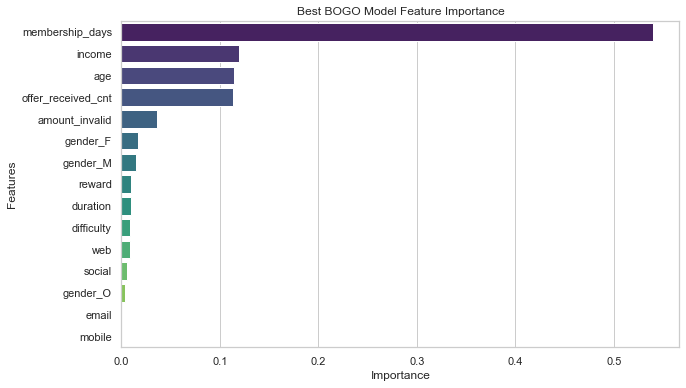

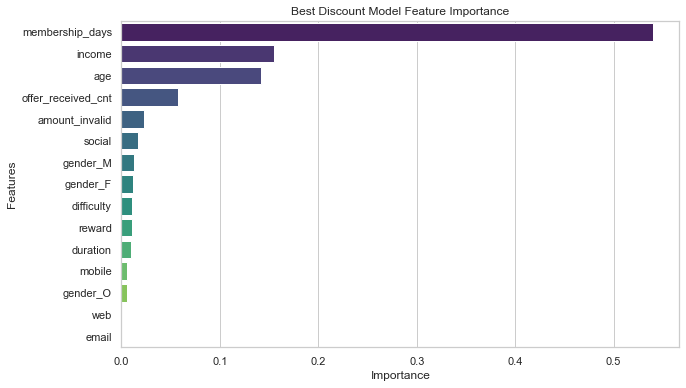

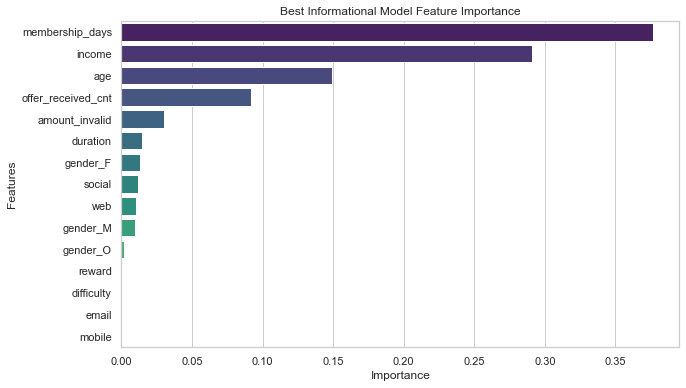

In [91]:
# Set the style for all plots
sns.set(style='whitegrid')

# Define a function to plot feature importances
def plot_feature_importance(model, feature_names, title):
    # Calculate feature importances
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index=feature_names,
                                       columns=['importance']).sort_values('importance', ascending=False)
    
    # Create a bar plot for feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y=feature_importances.index, data=feature_importances, palette='viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# BOGO Model Feature Importance
features, target = create_target_feature(bogo_final_offers, drop_cols_prep)

# Print feature importance
plot_feature_importance(bogo_rf_2, features.columns, 'Best BOGO Model Feature Importance')

# Discount Model Feature Importance
features, target = create_target_feature(discount_final_offers, drop_cols_prep)

# Print feature importance
plot_feature_importance(discount_rf_2, features.columns, 'Best Discount Model Feature Importance')

# Informational Model Feature Importance
features, target = create_target_feature(dataset_offers, drop_cols_prep)

# Print feature importance
plot_feature_importance(info_rf_2, features.columns, 'Best Informational Model Feature Importance')


# Feature Importance Analysis

After analyzing feature importance to understand the key drivers of effective offers, we've made the following observations across all three offer types:

- **Tenure of Membership**: The most crucial driver of an effective offer is the customer's tenure of membership with Starbucks. Longer membership durations are strongly correlated with a higher likelihood of responding to offers.

- **Income**: Income is consistently the second most important feature in all three models, indicating its significance in predicting offer effectiveness.

Now, let's delve into the specific findings for each offer type:

## BOGO Offers

For BOGO offers, the feature importance hierarchy is as follows:

1. **Tenure of Membership**: This feature dominates as the most critical factor.
2. **Income**: Income is the second most important feature.
3. **Age**: Age ranks third in importance.
4. **Offer Received Count**: Offer received count is fourth, but its impact is relatively smaller.

## Discount Offers

In the case of discount offers, the importance of features is structured as follows:

1. **Tenure of Membership**: Membership tenure remains the top predictor.
2. **Age and Income**: Age and income are the subsequent important variables, though their influence is relatively modest.

## Informational Offers

For informational offers, the feature importances are more evenly distributed compared to BOGO and discount models. The feature importance hierarchy is as follows:

1. **Tenure of Membership**: Still the most influential feature.
2. **Income**: Income ranks second in importance.
3. **Age**: Age is the third most important variable.
4. **Social Channel**: Interestingly, the social channel feature is the fourth most important feature in predicting the effectiveness of informational offers.

These insights provide a comprehensive understanding of the main drivers for effective offers across different offer types.



## Findings

I had started out with 2 business questions:

1. What are the main features influencing the effectiveness of an offer on the Starbucks app?
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?


# Findings

I initially set out to answer two primary business questions:

## Question 1: Main Features Influencing Offer Effectiveness

I investigated the primary features influencing the effectiveness of offers on the Starbucks app. The key findings are as follows:

- **Membership Tenure**: Across all three offer types, membership tenure emerged as the most significant predictor of offer effectiveness.

- **Income and Age**: The top three variables influencing offer effectiveness were consistently membership tenure, income, and age. However, the order of importance between income and age varied depending on the offer type.

- **Offer Type Differences**: While the top features remained consistent, there were differences in the distribution of feature importances for each offer type. BOGO and discount offers had relatively equal importance among their top features, while informational offers showed a more balanced distribution, with income being the second most important variable.

## Question 2: Predicting User Offer Uptake

I aimed to determine whether the provided data, including offer characteristics and user demographics, could predict user offer uptake. Here are the key outcomes:

- **Model Accuracy**: I employed three separate models to predict the effectiveness of each offer type. The accuracy results were as follows:
    - BOGO Model: 82.87% accuracy.
    - Discount Model: 87.38% accuracy.
    - Informational Model: 75.23% accuracy.

These values of accuracy for different types of abovementioned offers are acceptable and reasonable. However, the accuracy of the model for the "informational offer" is below 80% which is also fine since this offer is just for the customers' information.
 
